# Ready to be the next generation 6God ? 

It's generaly acknowledge that there is nothing better than learning by doing. I've been following a lot of tutorials 
latetly about AI & NLP (Natural Language Processing ). So as I've always been a rap music fan I thought it could be 
awsome to apply this to the technics I've been learning about machin learning and deep learning. 
**And here is how I found my self writing a Drake type Rap lyrics generator**

What you'll see here next is the different steps I've chosen to take to build this little project.
* Data gathering 
* Data preprocessing 
    * Tokenizing the data set
    * Define the alphabet 
    * Create training sequences 
    * Label Encode training sequences &  One-Hot-Encode the dataset 
* The model 
    * Intro to the model used 
    * RNN and LSTM
    * Building the model 
* Generating the lyrics
    
From now on I'll try to comment every cell of code so that you can get all what I'm doing during this or that specific cell. Feel free to reach out to me for any additionnal information ! 

Good reading ! 


Disclaimer : this document was built as a "teaching material" for the Christopher.ia a discovery volunteering group from Centrale Marseille. 



## Our data getter 

As you may have guessed already, in order to train our model to be the new rapper we need to teach him a bit of lyrics to make it rap like Drake (aka 6god ). To gather a data set I've simply scrapped a website like metrolyrics to get some songs from Drake's discography. 

If you want to get a good grasp on how to scrap a website I advice you to read this well documented tutorial : https://medium.freecodecamp.org/how-to-scrape-websites-with-python-and-beautifulsoup-5946935d93fe

For the data set used here I've just created the drake-songs.csv using this technic. You can find the script for this in the same git repository you got this notebook from in the lyrics_getter.py 

As you'll see there on that script I've selected some 140 songs from Drake's discography that are stored in the data/drake-songs.csv file ! 

So as a frist step you'll need to run that script to gather data or just clone the git repository and you'll have it done. The next step is to process a bit our data to make it exploitable. The idea here is to change the lyrics into just raw text : no upper case letters, no ponctuation; just letters sequences and spaces. 


Let's import all the librarie we'll need for our work. 

In [3]:
%matplotlib inline
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
import random
import sys
import io
import re
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data processing 

In [4]:
#Reading the songs from the csv
songs = pd.read_csv('data/drake-songs.csv')

Tokeninzing the data into characters to feed to our model as it's a character based model

In [5]:
#gathering all the lyrics in one text check the lenght to see the result (normaly =367372 words)
text = ''

for index, row in songs['lyrics'].iteritems():
    cleaned = str(row).lower().replace(' ', '\n')
    text = text + " ".join(re.findall(r"[a-z']+", cleaned))
    
len(text)

367372

Great, now we have all the characters that might appear in our trainign data set from the previous tokenaziation step. In order to feed it to the model we need to check out all the unique characters. As our training data set is small we should stick to a small data set. So I've chosen to stay with the **english alphabet and some special characters** such as spaces.I've chosen to link every character to an index to make it easier to manipulate. Easy way out ! 

In [11]:

tokens = re.findall(r"[a-z'\s]", text)
# find all the unique chracters
chars = sorted(list(set(tokens)))
print('total chars:', len(chars))
char_indexes = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('This is what our dict looks like: ',char_indexes)

total chars: 28
This is what our dict looks like:  {' ': 0, "'": 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}


Now that we know exactly what are the characters our model we'll be predicting, we can start **creating the training data set**. Actually the model we'll be predicting the next character based on the previous ones. A simple idea that can be represented by the model calculating the $max_{all-seeds} (P(next char \mid seed ))$ where the next char is just the next character. So if we look at it closely, the model we'll learn that the most probable character after a "Trying to make it" is a " ". Yeah, just a space. Next sequences would be : "rying to make it " and the prediction we'll be "s" as the song says : "Trying to make it simple ..." 

Got it ? 
So basically all we're doing is creating inputs of 40 characters lenght for one character output. As simple as that. The most famialiar with data sets from you would notice that we are increasing the data set seize significantly by predicting one character at a time.  

Let's go for the creation of the data set ! 


In [7]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 20
step = 1 #the size at every iteration 
sentences = [] #List of sequences 
next_chars = [] #list of next characters that our model should predict

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

nb sequences: 367332


In [8]:
print('Vectorization...')
#Creat empty matrices for input and output sets
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
#We iterate over the matrices and covert all character to number 
# This is what we call Label Encoding process and One hot Vectorization :
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indexes[char]] = 1
    y[i, char_indexes[next_chars[i]]] = 1
print('Done')

Vectorization...
Done


## The model 

Actually in order to predict the next charcater based on the previous characters, we are going to use Reccuring Neural Network. More specificaly, Long Short Term Memory Networks. If you're unfamiliar with thse models here are the best tutorials I've found on the net that can be very helpful. I strongly advise you to read these : 

* RNN : https://towardsdatascience.com/introduction-to-recurrent-neural-network-27202c3945f3 by Pranoy Radhakrishnan
* LSTM : https://medium.com/@kangeugine/long-short-term-memory-lstm-concept-cb3283934359 by Eugine Kang

To build the model, I'm not going to reinvent boiling water. If you look a bit at the documentation of Keras you'll find easily that LSTM is already implemented. Only need to give it the right inputs and form the right outputs. 

Nothing crazy done here only building the model ! 

In [14]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
print('Done')

Build model...
Done


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
_________________________________________________________________
activation_1 (Activation)    (None, 28)                0         
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________


In [21]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [22]:
def on_epoch_end(epoch, logs):
    print('Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5]:
        print('diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [23]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    x, 
    y,
    batch_size=128,
    epochs=10,
    callbacks=[print_callback]
)

Epoch 1/10
122444/122444 [==============================] - 90s 731us/step - loss: 1.9469
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ntial i'm here for you niggas i guess a "
ntial i'm here for you niggas i guess a from the the better the she the the with the the the still i con't the and i con't the the the still the and i see i could the the some to the to stort the starte i con a from the the the the some the show the some the the the the the some the the see the she you still the she the to better i con a prech the the still i got to the better the the some the some the shot i see i got the she the the s
----- diversity: 0.5
----- Generating with seed: "ntial i'm here for you niggas i guess a "
ntial i'm here for you niggas i guess a frim you could the to and me firdd i could i'm to thing i feel nigga in the broce i seen this you could thing i fuck to fick the money never the the plote the starting you seen i'm to cout the the troped i se

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


i get it i'm so more i'm going the same i see they say i spend the move i see i get it i got a mocher i got a grown and i got a never got it all i should think i'm to me and i got a spack i get it i get it i get it i get it i get it i get it i get 
----- diversity: 0.5
----- Generating with seed: "g in this elevator zone alone i'm up so "
g in this elevator zone alone i'm up so from the crip to success i got to fun it man we wanna spange things with me on the for me they gon' i'm surriends all move and i'm going i get thet alone i hear here and from me i can't be to she can see i need to see somebody wanna plan hope bout on one me and is i can packed gettin' some go huse i don't know me i talk you don't know when you can i hope she dance and i'm going post on my rone in 
Epoch 5/10
122444/122444 [==============================] - 79s 642us/step - loss: 1.3898
----- Generating text after Epoch: 4
----- diversity: 0.2
----- Generating with seed: "you looking good girl go go go get em gi"

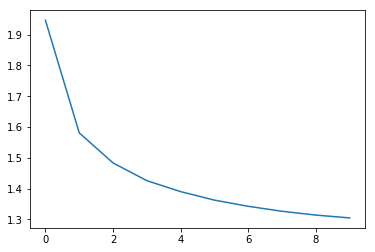

In [24]:
plt.plot(history.history['loss'])

## The generator : 

Here is your generator. Feel free to send me any comments or feedback on this. Here are my contact info :
* Email : laajajhamza@gmail.com
* Github : https://github.com/hamazing 

Thanks for reading ! 


PS : run all the cells of the notebook one by one to get the input case here 

In [30]:
def generate_output():
    generated = ''
    usr_input = input("Type in the seed and let the AI generate some Drake type lyrics for you :  ")

    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 0.2)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [34]:
Tx = 40
generate_output()

Type in the seed and let the AI generat some Drake type lyrics :  too bad


Here is your poem: 

too bad and the back and the same the same there i don't wanna be some the same there i all the same there i don't wanna be a time i wanna be some the bound to say i don't ever had the still the came i don't wanna be in the still with the bound the same there i don't know i don't want the creases there i don't wanna be some the club on my friends and i'm talkin' to the same there i don't wanna be a first

In [35]:
import utils

In [ ]:
utils.save_model_weights(model)